In [1]:
from agentflow.agents import DDPG
from agentflow.buffers import BufferMap, PrioritizedBufferMap
from agentflow.numpy.ops import onehot
from agentflow.tensorflow.nn import dense_net
from agentflow.tensorflow.ops import normalize_ema, exponential_moving_average
import tensorflow as tf
import numpy as np
import pandas as pd

def build_net_fn(hidden_dims,hidden_layers,output_dim,batchnorm):
    def net_fn(h,training=False):
        h = dense_net(h,hidden_dims,hidden_layers,activation=tf.nn.elu,
                      batchnorm=batchnorm,training=training)
        return tf.layers.dense(h,output_dim)
    return net_fn

def build_policy_fn(hidden_dims,hidden_layers,output_dim,batchnorm,normalize_inputs=True):
    net_fn = build_net_fn(hidden_dims,hidden_layers,output_dim,batchnorm)
    def policy_fn(state,training=False):
        if normalize_inputs:
            state, _ = normalize_ema(state,training)
        h = net_fn(state,training)
        return tf.nn.softmax(h,axis=-1)
    return policy_fn

def build_q_fn(hidden_dims,hidden_layers,output_dim,batchnorm,normalize_inputs=True):
    net_fn = build_net_fn(hidden_dims,hidden_layers,output_dim,batchnorm)
    def q_fn(state,action,training=False):
        if normalize_inputs:
            state, _ = normalize_ema(state,training)
        h = tf.concat([state,action],axis=1)
        return net_fn(h,training)
    return q_fn

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
STEPS = 256
UNITS = 32
LAYERS = 2
BATCHSIZE = 16

In [183]:
class Model1(object):
    
    def __init__(self,units=UNITS,layers=LAYERS):
        with tf.variable_scope('model1') as scope:
            
            self.inputs = inputs = {
                'state': tf.placeholder(tf.float32,shape=(None,1)),
                'state2': tf.placeholder(tf.float32,shape=(None,1)),
                'done': tf.placeholder(tf.float32,shape=(None,)),
                'learning_rate': tf.placeholder(tf.float32,shape=()),
                'gamma': tf.placeholder(tf.float32,shape=()),
            }
            v_fn = build_net_fn(units,layers,1,batchnorm=False)

            with tf.variable_scope('model'):
                V_state = v_fn(inputs['state'],training=True)

            with tf.variable_scope('model',reuse=True):
                V_state2 = v_fn(inputs['state2'])
                
            self.V_state = tf.reshape(V_state,[-1])
            self.V_state2 = tf.reshape(V_state2,[-1])
            
            target = 1. + (1-inputs['done'])*inputs['gamma']*self.V_state2
            self.td_err = self.V_state-tf.stop_gradient(target)
            self.losses = 0.5*tf.square(self.td_err)
            self.loss = tf.reduce_mean(self.losses)
            
            self.optimizer = tf.train.GradientDescentOptimizer(inputs['learning_rate'])
            self.train_op = self.optimizer.minimize(self.loss)


def get_gradient_matrix_old(var_list,objective,batchsize):
    gradient_stack = []
    for i in range(batchsize):
        grad_i = tf.gradients(objective[i],var_list)
        grad_i_flat = tf.concat([tf.reshape(g,[-1]) for g in grad_i],axis=0)
        gradient_stack.append(grad_i_flat)
    gradients = tf.stack(gradient_stack)
    return gradients


def get_gradient_matrix(var_list,objective):
    def func(obj_i):
        grad_i = tf.gradients(obj_i,var_list)
        #grad_i_flat = tf.concat([tf.reshape(g,[-1]) for g in grad_i],axis=0)
        return grad_i
    grads = tf.vectorized_map(func,objective)
    return grads

def get_gradient_matrix(var_list,objective):
    def func(obj_i):
        grad_i = tf.gradients(obj_i,var_list)
        grad_i = tf.concat([tf.reshape(g,[-1]) for g in grad_i],axis=0)
        return grad_i
    grads = tf.vectorized_map(func,objective)
    nvars = sum([np.prod(v.shape) for v in var_list])
    grads = tf.reshape(grads,[-1,nvars])
    return grads
    
def get_modified_gradients_pinv(var_list,y_pred,y2_pred,td_err,alpha,damping,beta,batchsize):
    gradients = get_gradient_matrix(var_list,y_pred)
    gradients2 = get_gradient_matrix(var_list,y2_pred)

    #pinv_grad = tf.linalg.pinv(gradients)
    #pinv_grad_T = tf.transpose(pinv_grad)
    gTg = tf.matmul(tf.transpose(gradients),gradients)
    g2Tg2 = tf.matmul(tf.transpose(gradients2),gradients2)
    gTg_damped = alpha*gTg + damping*tf.eye(tf.shape(gradients)[1]) + beta*g2Tg2
    gTg_damped_inv = tf.linalg.inv(gTg_damped)
    pinv_grad_T = tf.matmul(gradients,gTg_damped_inv)
    pinv_grad = tf.transpose(pinv_grad_T)

    #modified_grad_flat = tf.reduce_mean(pinv_grad_T*td_err[:,None],axis=0)
    
    if beta > 0:
        grads = tf.concat([gradients,gradients2],axis=0)
        zeros = tf.zeros(tf.shape(y_pred)[0],tf.float32)
        td_err = tf.concat([td_err,zeros],axis=0)
    else:
        grads = gradients
    
    modified_grad_flat = tf.linalg.lstsq(grads,td_err[:,None],fast=True,l2_regularizer=damping)
    modified_grad_flat = modified_grad_flat/tf.cast(tf.shape(grads)[0],tf.float32)

    modified_grad = []
    i = 0
    for v in var_list:
        w = np.prod(v.shape).value
        g = tf.reshape(modified_grad_flat[i:i+w],v.shape)
        modified_grad.append((g,v))
        i += w
        
    supplementary_output = {
        #'pinv_grad': pinv_grad,
        #'pinv_grad_T': pinv_grad_T,
        'gradients': gradients,
        #'gTg_norm': tf.linalg.norm(gTg_damped),
    }
    return modified_grad, supplementary_output

class Model2(object):
    
    def __init__(self,units=UNITS,layers=LAYERS,batchsize=BATCHSIZE,alpha=1.,damping=1.,beta=1.,name='model2'):
        if batchsize is None:
            batchsize = STEPS
        with tf.variable_scope(name) as scope:
            
            inputs = {
                'state': tf.placeholder(tf.float32,shape=(None,1)),
                'state2': tf.placeholder(tf.float32,shape=(None,1)),
                'done': tf.placeholder(tf.float32,shape=(None,)),
                'learning_rate': tf.placeholder(tf.float32,shape=()),
                'gamma': tf.placeholder(tf.float32,shape=()),
            }
            self.inputs = inputs
            
            v_fn = build_net_fn(units,layers,1,batchnorm=False)

            with tf.variable_scope('model'):
                V_state = v_fn(inputs['state'],training=True)

            with tf.variable_scope('model',reuse=True):
                V_state2 = v_fn(inputs['state2'])
                
            self.V_state = tf.reshape(V_state,[-1])
            self.V_state2 = tf.reshape(V_state2,[-1])
            
            target = 1. + (1-inputs['done'])*inputs['gamma']*self.V_state2
            self.td_err = self.V_state-tf.stop_gradient(target)
            self.losses = 0.5*tf.square(self.td_err)
            self.loss = tf.reduce_mean(self.losses)
            
            var_list = tf.trainable_variables(scope=scope.name)
            #self.modified_grad, self.supplementary_output = get_modified_gradients(
            #    var_list,self.losses,batchsize)
            self.modified_grad, self.supplementary_output = get_modified_gradients_pinv(
                var_list,self.V_state,self.V_state2,self.td_err,alpha,damping,beta,batchsize)
            
            self.optimizer = tf.train.GradientDescentOptimizer(inputs['learning_rate'])
            self.train_op = self.optimizer.apply_gradients(self.modified_grad)

class Logs(object):
    
    def __init__(self):
        self.logs = {}
        
    def append(self,key,val):
        if key not in self.logs:
            self.logs[key] = []
        self.logs[key].append(val)
        
    def append_dict(self,inp):
        for k in inp:
            self.append(k,inp[k])
        
    def stack(self,key=None):
        if key is None:
            return {key:self.stack(key) for key in self.logs}
        else:
            return np.stack(self.logs[key])

In [184]:
tf.reset_default_graph()
model1 = Model1()
model2 = Model2(name='model2',alpha=1,damping=0.1,beta=0)
model3 = Model2(name='model3',alpha=1,damping=1,beta=1)

In [166]:
T = 1000
gamma = 0.99

STATE = np.arange(STEPS).astype(float)
STATE2 = STATE + 1
DONE = (STATE2 == STEPS).astype(float)
STATE2 = STATE2 % STEPS
MEAN = STATE.mean()
STD = STATE.std()
STATE_NORMED = (STATE-MEAN)/STD
STATE2_NORMED = (STATE2-MEAN)/STD

In [144]:
def learn(model,lr,gamma=gamma,T=T,batchsize=None):
    logs = Logs()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        pb = tf.keras.utils.Progbar(T,stateful_metrics=['loss'])
        for t in range(T):

            state = STATE_NORMED
            state2 = STATE2_NORMED
            done = DONE
            
            if batchsize is not None:
                idx = np.random.choice(STEPS,size=batchsize)
                state = state[idx]
                state2 = state2[idx]
                done = done[idx]

            #state = state + 0.02*np.random.randn(*state.shape)
            #state2 = state2 + 0.02*np.random.randn(*state2.shape)
            #i = np.random.choice(STEPS,size=batchsize)

            sess.run(
                [
                    model.train_op
                ],
                {
                    model.inputs['state']: state[:,None],
                    model.inputs['state2']: state2[:,None],
                    model.inputs['done']: done[:],
                    model.inputs['learning_rate']: lr,
                    model.inputs['gamma']: gamma,
                })


            state = STATE_NORMED
            state2 = STATE2_NORMED
            done = DONE
            output = sess.run(
                {
                    'V_state': model.V_state,
                    'td_err': model.td_err,
                    'loss': model.loss,
                    'losses': model.losses,
                },
                {
                    model.inputs['state']: state[:,None],
                    model.inputs['state2']: state2[:,None],
                    model.inputs['done']: done[:],
                    model.inputs['learning_rate']: lr,
                    model.inputs['gamma']: gamma,
                })
            
            logs.append_dict(output)

            state = STATE_NORMED
            state2 = STATE2_NORMED
            done = DONE
            
            pb.add(1,[('loss',output['loss'])])
    return logs

In [70]:
logs1 = learn(model1,1e-2,batchsize=BATCHSIZE)

1000/1000 [==============================] - 1s 1ms/step - loss: 0.0153


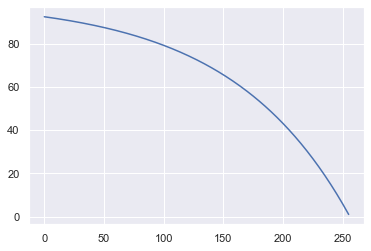

In [71]:
v_true = np.ones(STEPS)
for i in range(STEPS-1)[::-1]:
    v_true[i] += gamma*v_true[i+1]
plt.plot(v_true)

/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


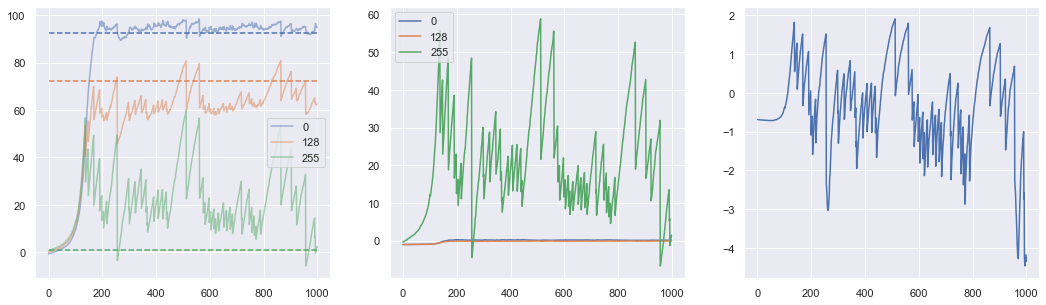

In [72]:
plt.figure(figsize=(18,5))

logs = logs1
V = logs.stack('V_state')
E = logs.stack('td_err')
L = logs.stack('losses')
for i,k in enumerate([0,STEPS//2,STEPS-1]):
    plt.subplot(1,3,1)
    plt.plot(V[:,k],label=str(k),alpha=0.5)
    plt.plot(np.arange(T),np.ones(T)*v_true[k],linestyle='dashed',color=seaborn.color_palette()[i])
    _ = plt.legend()

    plt.subplot(1,3,2)
    plt.plot(E[:,k],label=str(k))
    _ = plt.legend()
    
plt.subplot(1,3,3)
plt.plot(np.log(L.mean(axis=1)))

In [185]:
logs2 = learn(model2,4,T=1000,batchsize=BATCHSIZE)

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0047


/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


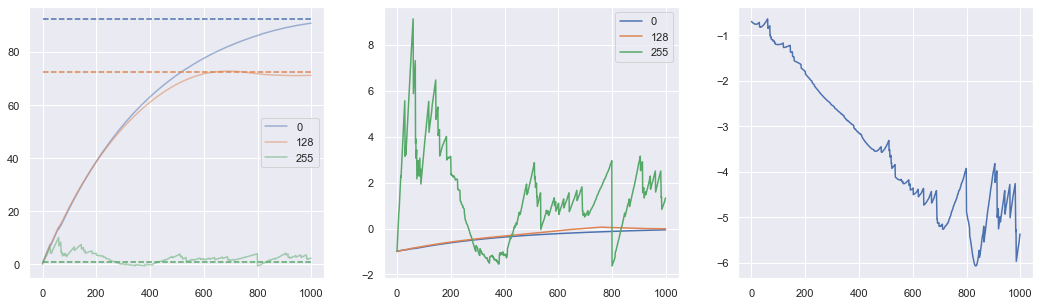

In [186]:
plt.figure(figsize=(18,5))

logs = logs2
V = logs.stack('V_state')
E = logs.stack('td_err')
L = logs.stack('losses')
for i,k in enumerate([0,STEPS//2,STEPS-1]):
    plt.subplot(1,3,1)
    plt.plot(V[:,k],label=str(k),alpha=0.5)
    plt.plot(np.arange(T),np.ones(T)*v_true[k],linestyle='dashed',color=seaborn.color_palette()[i])
    _ = plt.legend()

    plt.subplot(1,3,2)
    plt.plot(E[:,k],label=str(k))
    _ = plt.legend()
    
plt.subplot(1,3,3)
plt.plot(np.log(L.mean(axis=1)))

In [195]:
logs3 = learn(model3,20,T=1000,batchsize=BATCHSIZE)

1000/1000 [==============================] - 2s 2ms/step - loss: 3.1143e-04


/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


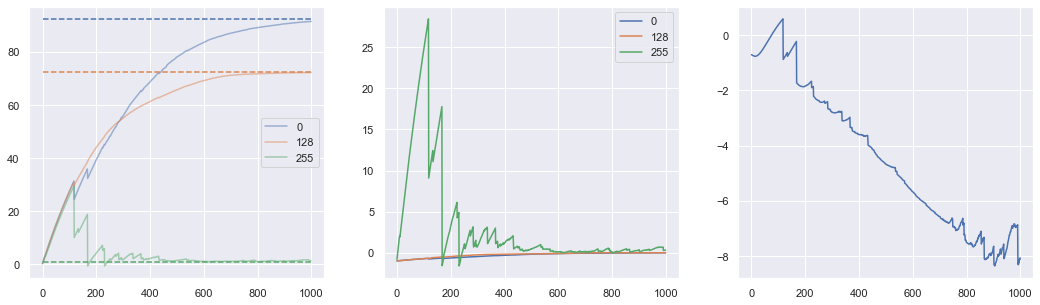

In [196]:
plt.figure(figsize=(18,5))

logs = logs3
V = logs.stack('V_state')
E = logs.stack('td_err')
L = logs.stack('losses')
for i,k in enumerate([0,STEPS//2,STEPS-1]):
    plt.subplot(1,3,1)
    plt.plot(V[:,k],label=str(k),alpha=0.5)
    plt.plot(np.arange(T),np.ones(T)*v_true[k],linestyle='dashed',color=seaborn.color_palette()[i])
    _ = plt.legend()

    plt.subplot(1,3,2)
    plt.plot(E[:,k],label=str(k))
    _ = plt.legend()
    
plt.subplot(1,3,3)
plt.plot(np.log(L.mean(axis=1)))

## Multiple runs

In [197]:
T = 1000
S = 10
logs1S = [learn(model1,1e-2,T=T,batchsize=BATCHSIZE) for s in range(S)]

1000/1000 [==============================] - 1s 977us/step - loss: 0.0104


In [199]:
logs2S = [learn(model2,2,T=T,batchsize=BATCHSIZE) for s in range(S)]

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0229


In [200]:
logs3S = [learn(model3,20,T=T,batchsize=BATCHSIZE) for s in range(S)]

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0012


In [201]:
def plot_percentiles(x):
    mean = x.mean(axis=0)
    p10 = np.percentile(x,5,axis=0)
    p90 = np.percentile(x,95,axis=0)
    [a] = plt.plot(mean,alpha=0.7)
    plt.fill_between(range(len(p10)),p10,p90,color=a.get_color(),alpha=0.2)

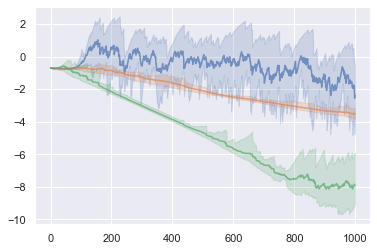

In [202]:
logsS = [logs1S,logs2S,logs3S]
for logs in logsS:
    L = np.stack([log.stack('loss') for log in logs])
    plot_percentiles(np.log(L+1e-32))

W0223 23:48:50.430202 4584179136 legend.py:1282] No handles with labels found to put in legend.
W0223 23:48:50.443330 4584179136 legend.py:1282] No handles with labels found to put in legend.
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
W0223 23:48:50.448749 4584179136 legend.py:1282] No handles with labels found to put in legend.
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, th

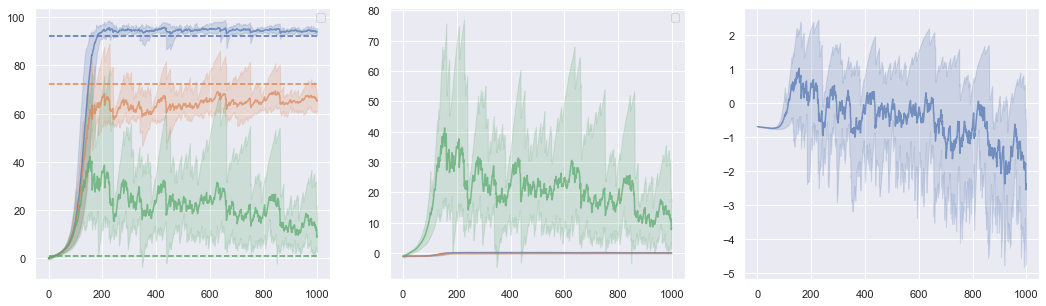

In [203]:
plt.figure(figsize=(18,5))

logs = logs1S
V = np.stack([log.stack('V_state') for log in logs])
E = np.stack([log.stack('td_err') for log in logs])
L = np.stack([log.stack('loss') for log in logs])
for i,k in enumerate([0,STEPS//2,STEPS-1]):
    plt.subplot(1,3,1)
    plot_percentiles(V[:,:,k])
    plt.plot(np.arange(T),np.ones(T)*v_true[k],linestyle='dashed',color=seaborn.color_palette()[i])
    _ = plt.legend()

    plt.subplot(1,3,2)
    plot_percentiles(E[:,:,k])
    _ = plt.legend()
    
plt.subplot(1,3,3)
plot_percentiles(np.log(L+1e-32))

W0223 23:48:51.345880 4584179136 legend.py:1282] No handles with labels found to put in legend.
W0223 23:48:51.359442 4584179136 legend.py:1282] No handles with labels found to put in legend.
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
W0223 23:48:51.365694 4584179136 legend.py:1282] No handles with labels found to put in legend.
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, th

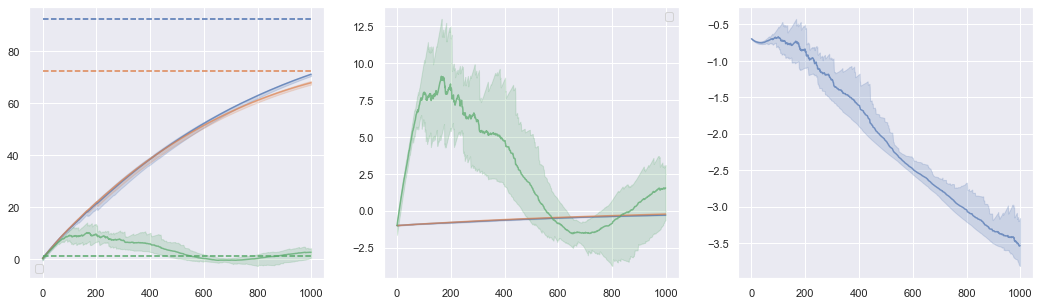

In [204]:
plt.figure(figsize=(18,5))

logs = logs2S
V = np.stack([log.stack('V_state') for log in logs])
E = np.stack([log.stack('td_err') for log in logs])
L = np.stack([log.stack('loss') for log in logs])
for i,k in enumerate([0,STEPS//2,STEPS-1]):
    plt.subplot(1,3,1)
    plot_percentiles(V[:,:,k])
    plt.plot(np.arange(T),np.ones(T)*v_true[k],linestyle='dashed',color=seaborn.color_palette()[i])
    _ = plt.legend()

    plt.subplot(1,3,2)
    plot_percentiles(E[:,:,k])
    _ = plt.legend()
    
plt.subplot(1,3,3)
plot_percentiles(np.log(L+1e-32))

W0223 23:48:52.116304 4584179136 legend.py:1282] No handles with labels found to put in legend.
W0223 23:48:52.129017 4584179136 legend.py:1282] No handles with labels found to put in legend.
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
W0223 23:48:52.134859 4584179136 legend.py:1282] No handles with labels found to put in legend.
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, th

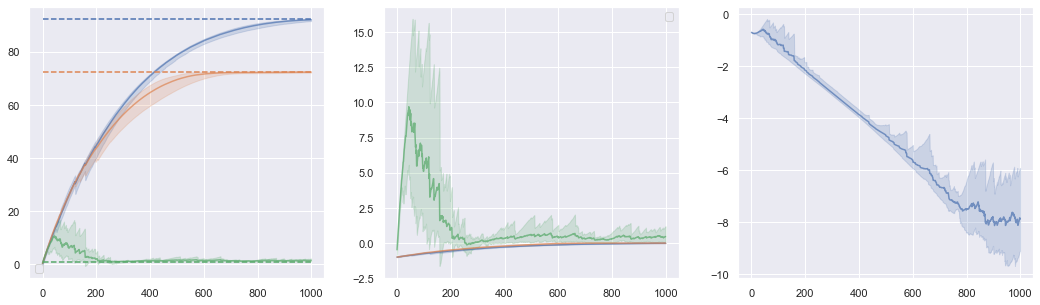

In [205]:
plt.figure(figsize=(18,5))

logs = logs3S
V = np.stack([log.stack('V_state') for log in logs])
E = np.stack([log.stack('td_err') for log in logs])
L = np.stack([log.stack('loss') for log in logs])
for i,k in enumerate([0,STEPS//2,STEPS-1]):
    plt.subplot(1,3,1)
    plot_percentiles(V[:,:,k])
    plt.plot(np.arange(T),np.ones(T)*v_true[k],linestyle='dashed',color=seaborn.color_palette()[i])
    _ = plt.legend()

    plt.subplot(1,3,2)
    plot_percentiles(E[:,:,k])
    _ = plt.legend()
    
plt.subplot(1,3,3)
plot_percentiles(np.log(L+1e-32))